<h1 align="center">Task 2: Deep Learning based Quark-Gluon Classification</h1>

---

● __Data Preparation__: Please train your model on 80% of the data and evaluate on the remaining 20%. Please make sure not to overfit on the test dataset - it will be checked with an independent sample.

● __Model Training__: Train a __VGG13__ model and another model of your choice.

---

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pyarrow.parquet as pq

import gc
from random import shuffle

In [3]:
import torch
from torch import nn
from torch import optim

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, ConcatDataset

from torchvision import models

/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


---

<h2 align="center">Phase I: Data Preparation</h2>

__Aim__: Please train your model on 80% of the data and evaluate on the remaining 20%. Please make sure not to overfit on the test dataset - it will be checked with an independent sample.

---

In [4]:
# File paths
file1 = "dataset/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet"
file2 = "dataset/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet"
file3 = "dataset/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet"

In [5]:
# Load data files
class ParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None 
    
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jets']= 1.*np.float32(data['X_jets'][0])#/data['mGG']
        data['X_jets']=data['X_jets'][0][:80000]
        
        data = dict(data)
        return torch.as_tensor(np.expand_dims(data["X_jets"], axis = 0)), int(data["y"][0])
    
    def __len__(self):
        return self.parquet.num_row_groups

    @classmethod
    def from_files(cls, filenames):
        return ConcatDataset([cls(fname) for fname in filenames])

In [6]:
# Load data files
class BatchedParquetDataset(Dataset):
    def __init__(self, filename, batch_size):
        super().__init__()

        self.batch_size = batch_size
        self.parquet = pq.ParquetFile(filename)
        self.cols = None
        
        self.size = self.parquet.num_row_groups

        self.remainder = self.size % self.batch_size

        self.batch_indices = list(range(0, self.size, self.batch_size))
        self.batch_indices = list(
            zip(
                self.batch_indices,
                self.batch_indices[1:] + [self.batch_indices[-1] + (self.remainder if self.remainder > 0 else self.batch_size)]
            )
        )
    
    def __getitem__(self, index):
        indexes = range(*self.batch_indices[index])
        data = self.parquet.read_row_groups(indexes, columns=self.cols).columns

        image = torch.as_tensor(data[0].to_pylist())
        targets = torch.as_tensor(data[-1].to_pylist(), dtype = torch.long)
        
        return image, targets
    
    def __len__(self):
        return len(self.batch_indices)

    @classmethod
    def from_files(cls, filenames, batch_size):
        return ConcatDataset([cls(fname, batch_size) for fname in filenames])

In [7]:
batch_size = 64

In [8]:
bdata = BatchedParquetDataset.from_files(batch_size = batch_size, filenames = [file1, file2, file3])

In [9]:
sample = bdata[0]

In [10]:
sample[0].shape

torch.Size([64, 3, 125, 125])

In [11]:
sample[1].shape

torch.Size([64])

In [12]:
len(bdata) * batch_size

139392

In [13]:
train_data, test_data = random_split(bdata, lengths = [.8, .2])

class BatchedDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        return iter(super())

    def __next__(self):
        return 

In [14]:
train_dl = DataLoader(
    dataset = train_data,
    batch_size = 1,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

test_dl = DataLoader(
    dataset = test_data,
    batch_size = 1,
    shuffle = True,
    num_workers = 4,
    pin_memory = True
)

In [15]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
gc.collect()

40

---

<h2 align="center">Phase II: Model Training</h2>

__Aim__: Train a VGG13 model and another model of your choice.

---

In [17]:
model = models.resnet18(pretrained=True)

/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harkhymadhe/miniforge3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
class ParticleModel(nn.Module):
    def __init__(self, model, freeze = False, out_features = 2, channels = 2, height = 32, width = 32):
        super().__init__()
        self.backbone = model
        self.freeze = freeze
        
        self.channels = channels
        self.height = height
        self.width = width

        self.out_features = out_features
        self.layer_norm = nn.LayerNorm([self.channels, self.height, self.width])

        if self.freeze:
            for param in self.backbone.parameters():
                param.requires_grad_(False)

        in_ = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features = in_, out_features = out_features)

    def forward(self, x):
        x = self.layer_norm(x)
        return self.backbone(x)

In [20]:
def initialize_weights(model):
    for (name, weights) in filter(lambda x: x[1].requires_grad, model.named_parameters()):
        if name.split(".")[1] not in ["fc", "conv1"]:
            continue
        try:
            nn.init.kaiming_normal_(weights)
        except:
            nn.init.normal_(weights, 0., 0.05)
    
    return model

In this notebook, the pretrained weights will be finetuned. This is in contrast to the previous one, where the weights were kept frozen. Also, the learing rate is increased from 1e-4 to 1e-3.

__Update__: A learning rate of 1e-3 may be too small for non-frozen weights. I will now attempt to freeze the weights and leave the learning rate as is. Freezing the weights might even speed up training.

In [21]:
EPOCHS = 20
l2_lambda = 1e-4

criterion = nn.CrossEntropyLoss().to(DEVICE)

# Optimizer hyperparameters
LR = 1e-3
FACTOR = 100
AMSGRAD = False
BETAS = (.9, .999)
FREEZE = True

In [22]:
model = ParticleModel(
    model = model,
    freeze = FREEZE,
    channels = 3,
    height = 125,
    width = 125
).to(DEVICE)

In [23]:
model = initialize_weights(model)

In [24]:
opt = optim.AdamW(
    params = [{
        "params" : model.backbone.parameters(),
        "lr": LR
    }],
    lr=LR/FACTOR,
    amsgrad = AMSGRAD,
    betas = BETAS,
    weight_decay = l2_lambda
)

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
def training_loop(epochs, model, optimizer):
    TRAIN_LOSSES, TEST_LOSSES = [], []
    TRAIN_ACCS, TEST_ACCS = [], []

    for epoch in range(1, epochs + 1):
        train_losses, test_losses = [], []
        train_accs, test_accs = [], []

        model.train() # Set up training mode

        for batch in iter(train_dl):
            # X, y = collate_function(batch)
            X, y = batch
            X, y = X.squeeze().to(DEVICE), y.view(-1).to(DEVICE)

            y_pred = model(X)

            train_loss = criterion(y_pred, y.to(torch.long)) # Compare actual targets and predicted targets to get the loss
            train_loss.backward() # Backpropagate the loss
            
            optimizer.step()
            optimizer.zero_grad()

            train_losses.append(train_loss.detach().item())

            train_acc = accuracy_score(y.cpu().numpy(), y_pred.max(dim = -1).indices.cpu().numpy())
            train_accs.append(train_acc)

        torch.save(model.state_dict(), f"epoch_resnet_{epoch}_model.pt")

        with torch.no_grad(): # Turn off computational graph
            model.eval() # Set model to evaluation mode
            for batch in iter(test_dl):
                # X_, y_ = collate_function(batch)
                X_, y_ = batch
                X_, y_ = X_.squeeze().to(DEVICE), y_.view(-1).to(DEVICE)
    
                y_pred_ = model(X_)
    
                test_loss = criterion(y_pred_, y_.to(torch.long)) # Compare actual targets and predicted targets to get the loss
                test_losses.append(test_loss.item())

                test_acc = accuracy_score(y_.cpu().numpy(), y_pred_.max(dim = -1).indices.cpu().numpy())
                test_accs.append(test_acc)

        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_test_loss = sum(test_losses) / len(test_losses)

        avg_train_acc = sum(train_accs) / len(train_accs)
        avg_test_acc = sum(test_accs) / len(test_accs)

        print(
            f"Epoch: {epoch} | Train loss: {avg_train_loss: .3f} | Test loss: {avg_test_loss: .3f} |",
            f"Train accuracy: {avg_train_acc: .3f} | Test accuracy: {avg_test_acc: .3f} |"
        )

        TRAIN_LOSSES.append(avg_train_loss)
        TEST_LOSSES.append(avg_test_loss)

        TRAIN_ACCS.append(avg_train_acc)
        TEST_ACCS.append(avg_test_acc)

    # Clear CUDA cache
    torch.cuda.empty_cache()
    torch.clear_autocast_cache()

    return {
        "loss": [TRAIN_LOSSES, TEST_LOSSES],
        "accuracy": [TRAIN_ACCS, TEST_ACCS],
        "model": model
    }

In [27]:
# Train Resnet-18 with finetuning
model_results = training_loop(epochs = EPOCHS, optimizer = opt, model = model)

Epoch: 1 | Train loss:  0.644 | Test loss:  0.602 | Train accuracy:  0.668 | Test accuracy:  0.683 |
Epoch: 2 | Train loss:  0.604 | Test loss:  0.589 | Train accuracy:  0.685 | Test accuracy:  0.699 |
Epoch: 3 | Train loss:  0.607 | Test loss:  0.610 | Train accuracy:  0.683 | Test accuracy:  0.676 |
Epoch: 4 | Train loss:  0.603 | Test loss:  0.588 | Train accuracy:  0.686 | Test accuracy:  0.701 |
Epoch: 5 | Train loss:  0.605 | Test loss:  0.589 | Train accuracy:  0.684 | Test accuracy:  0.696 |
Epoch: 6 | Train loss:  0.603 | Test loss:  0.589 | Train accuracy:  0.685 | Test accuracy:  0.700 |
Epoch: 7 | Train loss:  0.604 | Test loss:  0.601 | Train accuracy:  0.685 | Test accuracy:  0.681 |
Epoch: 8 | Train loss:  0.603 | Test loss:  0.602 | Train accuracy:  0.687 | Test accuracy:  0.695 |
Epoch: 9 | Train loss:  0.603 | Test loss:  0.589 | Train accuracy:  0.686 | Test accuracy:  0.699 |
Epoch: 10 | Train loss:  0.604 | Test loss:  0.590 | Train accuracy:  0.686 | Test accuracy

In [28]:
# Persist model
torch.save(model_results["model"].state_dict(), "final_epoch_resnet_model.pt")

In [29]:
def visualize_results(history, key = None):
    if key is not None:
        TRAIN_RESULTS, TEST_RESULTS = history[key]

        plt.figure(figsize = (10, 3))

        plt.plot(range(EPOCHS), TRAIN_RESULTS, label = f"Training {key.capitalize()}")
        plt.plot(range(EPOCHS), TEST_RESULTS, label = f"Test {key.capitalize()}")

        plt.xlabel("Epochs")
        plt.ylabel(key.capitalize())

        plt.title(key.capitalize() + " Evolution for Train and Test Splits", fontsize = 16)

        plt.legend()
        plt.show(); plt.close("all")
    else:
        TRAIN_LOSSES, TEST_LOSSES = history["loss"]
        TRAIN_ACCS, TEST_ACCS = history["accuracy"]

        fig, ax = plt.subplots(1, 2, figsize = (15, 4))

        ax[0].plot(range(EPOCHS), TRAIN_LOSSES, label = "Training Loss")
        ax[0].plot(range(EPOCHS), TEST_LOSSES, label = "Test Loss")

        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")

        ax[0].set_title("Loss Evolution for Train and Test Splits", fontsize = 16)

        ax[1].plot(range(EPOCHS), TRAIN_ACCS, label = "Training Accuracy")
        ax[1].plot(range(EPOCHS), TEST_ACCS, label = "Test Accuracy")

        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Accuracy")

        ax[1].set_title("Accuracy Evolution for Train and Test Splits", fontsize = 16)

        plt.legend()
        plt.show(); plt.close("all")

    return

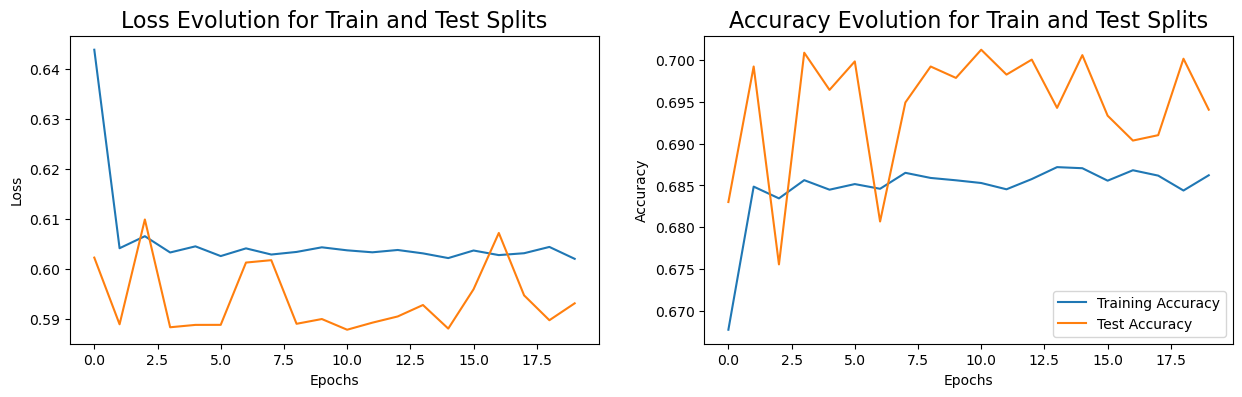

In [30]:
# VGG-13 with finetuning
visualize_results(model_results)